In [50]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [51]:
resolution = '10km'
n_clusters = 50
train_file = f'data/{resolution}_data.csv'
truth_file = f'data/{resolution}_truth.csv'

train_data = pd.read_csv(train_file)
Xraw = np.array(train_data[['lat', 'long']])
Yraw = np.array(train_data['generated_temp']).reshape(-1,1)
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)
print(Xraw.shape, Yraw.shape)

truth = pd.read_csv(truth_file)

(12700, 2) (12700, 1)


In [52]:
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 3000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1, 
                    'show_plot'   : True,
                }
}

cause_cluster_params =  {'model' : 'KMeans',
                        'model_params' : {'n_clusters' : n_clusters},
                        'verbose' : 0
}

In [53]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'running1' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to running1\experiment0012
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/3000
149/149 [==============================] - 0s 2ms/step - loss: 2.3148 - val_loss: 2.0484
Epoch 2/3000
149/149 [==============================] - 0s 1ms/step - loss: 1.8990 - val_loss: 1.7006
Epoch 3/3000
149/149 [==============================] - 0s 1ms/step - loss: 1.5994 - val_loss: 1.4572
Epoch 4/3000
149/149 [==============================] - 0s 1ms/step - loss: 1.3953 - val_loss: 1.2979
Epoch 5/3000
149/149 [==============================] - 0s 1ms/step - loss: 1.2647 - val_loss: 1.1979
Epoch 6/3000
149/149 [==============================] - 0s 1ms/step - loss: 1.1846 - val_loss: 1.1360
Epoch 7/3000
149/149 [==============================] - 0s 1ms/step - loss: 1.1332 - val_loss: 1.0951
Epoch 8/3000
149/149 [==============================] - 0s 1ms/step - loss: 1.0966 - val_loss: 1.0638
Epoch 9/3000
149/149 [==================

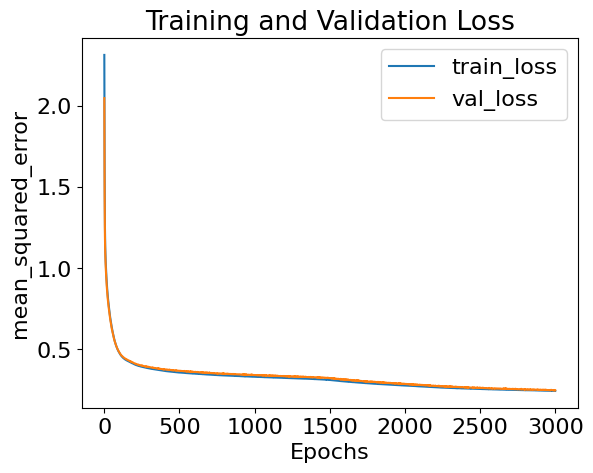

397/397 [==============================] - 0s 548us/step
Loading parameters from  tmp_checkpoints03022025164728\best_weights
Saving parameters to  running1\experiment0012\trained_blocks\CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [54]:
results = my_exp.train()

<Figure size 1200x600 with 0 Axes>

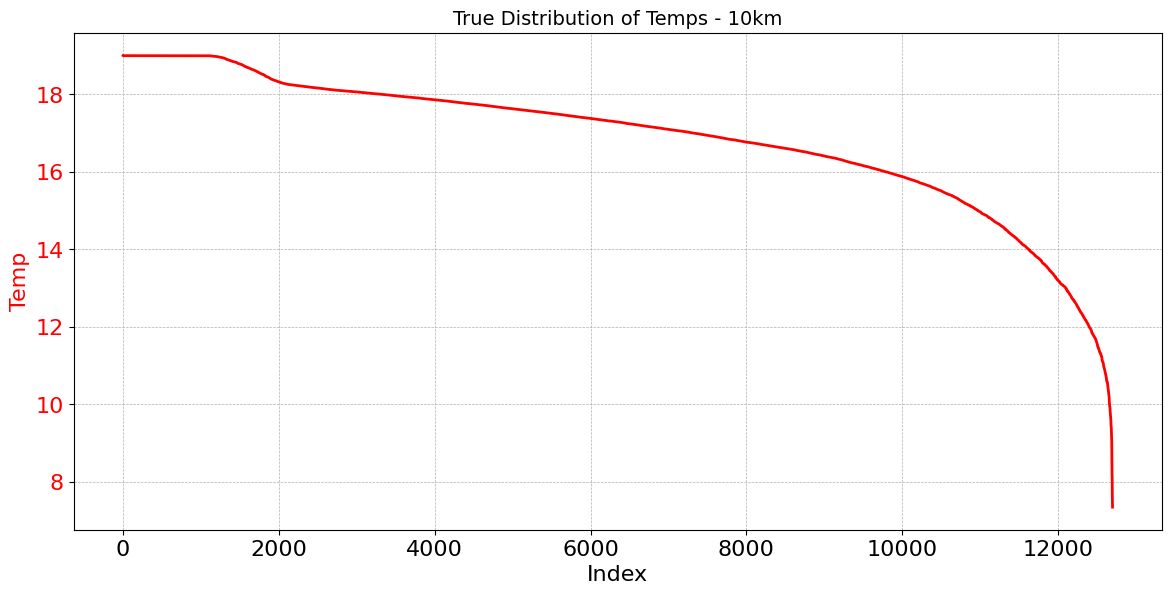

In [55]:
import matplotlib.pyplot as plt

# get true distribution of temperature

true_temps = truth['generated_temp']
sorted_idxs = true_temps.sort_values(ascending=False).index # to use later on
true_temps = true_temps[sorted_idxs]

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

line_color = 'red'
ax1.set_xlabel('Index')
ax1.set_ylabel('Temp', color=line_color)
ax1.plot([x for x in range(len(true_temps))], true_temps, color=line_color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=line_color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ymin, ymax = ax1.get_ylim()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'True Distribution of Temps - {resolution}', fontsize=14)
plt.show()

MIN TEMP FOR THIS DATASET: 7.38432107560956


<Figure size 1200x600 with 0 Axes>

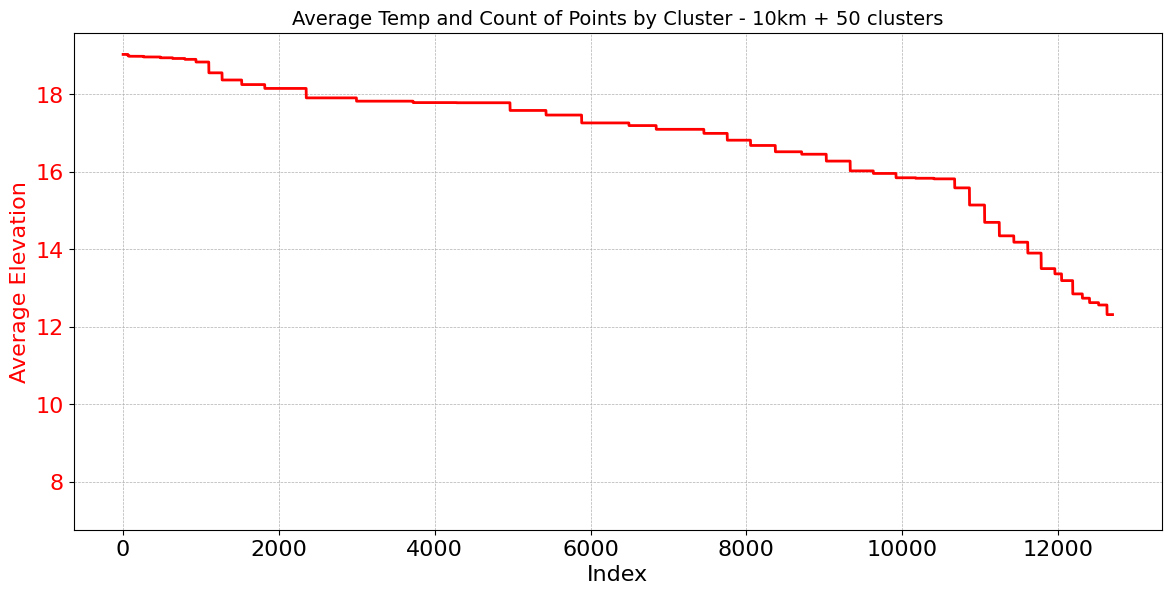

In [56]:
xlbls = results['CauseClusterer']['x_lbls']

plot_pred_distribution(train_data, xlbls, resolution, n_clusters, yminmax=(ymin, ymax))